## Import Packages and List of Stocks

In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from datetime import datetime, timedelta
from matplotlib.pyplot import figure
import plotly.express as px

from tqdm import tqdm

# List of Stocks
CoList = pd.read_excel('Input Files/List of ETFs.xlsx',sheet_name='Low_Missing')
CoList = CoList['Symbol']

# List of Proxies
proxies = pd.read_excel('Input Files/List of ETFs.xlsx',sheet_name='Proxies')
proxies = proxies['Symbol']

# List of Market Holidays
holiday_list = list(pd.read_excel("Input Files/Stock Market Holidays.xlsx")['Date'])
holiday_list = [holiday.strftime('%Y-%m-%d') for holiday in holiday_list]

################## Set Interval #######################
# 1min, 5min, 15min, 30min, 60min
minute_interval = '1min'

proxies

0    SPY
1    TLT
2    VXX
3    XLY
4    VNQ
Name: Symbol, dtype: object

### General Dataset Stats

In [2]:
co = 'AGG'

file_name = minute_interval + " " + co + ' cleaned_combined_stationary.csv'
file = pathlib.Path.cwd() / 'AlphaVantage Data'/ minute_interval / '6. Cleaned Combined Data Stationarity' / file_name 

df = pd.read_csv(file)

x = list(set(df['short_date']))
x = sorted(x)
print("First Day: ", x[0])
print("Last Day: ", x[-1])
print('Total Days: ',len(x))
print("Total Minutes: ", len(df.index))

First Day:  2019-11-19
Last Day:  2021-11-05
Total Days:  493
Total Minutes:  192270


### Check days

It's important to use the same timeframe for each ETF and Proxies so that the pricing data is used for the same days across the board.  This function gets the first and last day of each raw dataset.

Then, I make a DataFrame of the first and last days for each ETF and ensure that they are all the same values.

In [3]:
def first_last_day(co):
    # Get's earliest month
    file_name = minute_interval +co+' - year'+str(2)+'month'+str(12)+'.csv'
    file = pathlib.Path.cwd() / 'AlphaVantage Data'/ minute_interval/ '1. Raw Data' / co / file_name
    
    # Gets first day included in the file
    first_df = pd.read_csv(file)
    first_df.sort_values("time", inplace = True, ignore_index=True) 
    first_date = first_df['time'][0]
    first_date = datetime.strptime(first_date, '%Y-%m-%d %H:%M:%S')
    first_date = first_date.strftime('%Y-%m-%d')
    
    # Gets Most Recent Month
    file_name = minute_interval +co+' - year'+str(1)+'month'+str(1)+'.csv'
    file = pathlib.Path.cwd() / 'AlphaVantage Data'/ minute_interval/ '1. Raw Data' / co / file_name
    
    # Gets last day included in the file
    last_df = pd.read_csv(file)
    last_df.sort_values("time", inplace = True, ignore_index=True) 
    last_date = last_df.iloc[-1,0]
    last_date = datetime.strptime(last_date, '%Y-%m-%d %H:%M:%S')
    last_date = last_date.strftime('%Y-%m-%d')
    
    return first_date, last_date

tickers = []
first_dates = []
last_dates = []

# loop through all ETFs and Get first and Last Days represented
for co in CoList:
    first_date, last_date = first_last_day(co)
    tickers.append(co)
    first_dates.append(first_date)
    last_dates.append(last_date)

# Create DF of first and last days
first_last_df = pd.DataFrame()
first_last_df['Ticker'] = tickers
first_last_df['First Date'] = first_dates
first_last_df['Last Date'] = last_dates

# Prints unique values.  Should only be one day for each.
print("Unique First Day Values: ",first_last_df['First Date'].unique())
print("Unique Last Day Values: ",first_last_df['Last Date'].unique())

# Save a lot of this analysis

# See if folder exists for missing data log, if not, create it
destination = pathlib.Path.cwd() / 'Logs'/ 'First and Last Day Log' / minute_interval
if not destination.exists():
    destination.mkdir(parents=True, exist_ok=True)

file_name = minute_interval + ' First and Last Day Log.csv'
file = pathlib.Path.cwd() / 'Logs' / 'First and Last Day Log' / minute_interval / file_name

# Save File
first_last_df.to_csv(file, index=False)

Unique First Day Values:  ['2019-11-18']
Unique Last Day Values:  ['2021-11-05']


### Analyze Missing Data Counts

This function calculates the percent of missing data for the total dataset.  It reads the logs saved while cleaning the data and averages the missing percents, while also displaying the min and max values.  

The chosen universe of stocks had very little missing data.

In [4]:
avg_missings = []
for co in CoList:
    file_name = minute_interval + " " + co + ' Missing Values Log.csv'
    file = pathlib.Path.cwd() / 'Logs' / 'Missing Values Logs' / minute_interval / file_name
    df = pd.read_csv(file)
    avg_missings.append(statistics.mean(df['%Missing']))
    
print("Average Missing: ",round(statistics.mean(avg_missings),2),"%")
print("Maximum %Missing: ",round(max(avg_missings),2),"%")
print("Minimum %Missing: ",round(min(avg_missings),2),"%")

Average Missing:  0.52 %
Maximum %Missing:  5.73 %
Minimum %Missing:  0.12 %


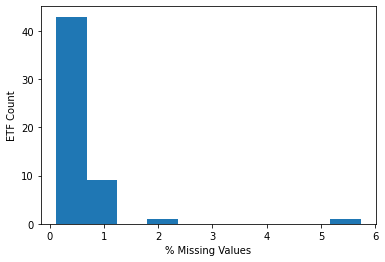

In [5]:
plt.hist(avg_missings, density=False, bins=10)
plt.ylabel('ETF Count')
plt.xlabel('% Missing Values');

### View Proxies' Price History

The plot shows the price history of the proxies and allows for a comparison.

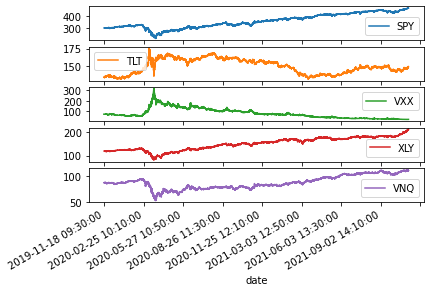

In [6]:
# Load proxy data and store close prices for each
proxy_dfs = []
for proxy in proxies:
    file_name = minute_interval + " " + proxy + ' cleaned_combined.csv'
    file = pathlib.Path.cwd() / 'AlphaVantage Data'/ minute_interval / '3. Cleaned Combined Data' / file_name 
    df = pd.read_csv(file)
    proxy_dfs.append(df['close'])
    
# Create new DF containing all proxies price data
close_df = pd.DataFrame(columns=list(proxies))
close_df['date'] = df['time']
for x in range(len(proxies)):
    close_df[proxies[x]] = proxy_dfs[x]
    
# Plot Results
plot_cols = ['SPY', 'TLT','VXX','XLY','VNQ']
plot_features = close_df[plot_cols]
plot_features.index = close_df['date']
_ = plot_features.plot(subplots=True)

### Plot Closing Prices

These plots show the stock prices during the previous two year period for a given stock.

In [7]:
def plot_closing_prices(co):      
    file_name = minute_interval + " " + co + ' cleaned_combined_stationary.csv'
    file = pathlib.Path.cwd() / 'AlphaVantage Data'/ minute_interval / '6. Cleaned Combined Data Stationarity' / file_name 

    df = pd.read_csv(file)

    actual_close_prices = np.asarray(df['close_prices'])

    plt.plot(range(len(actual_close_prices)), actual_close_prices)

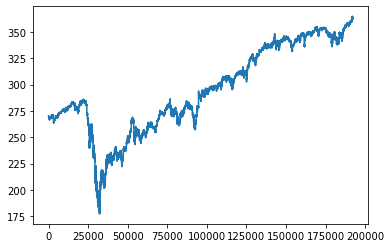

In [8]:
co = "DIA"
plot_closing_prices(co)

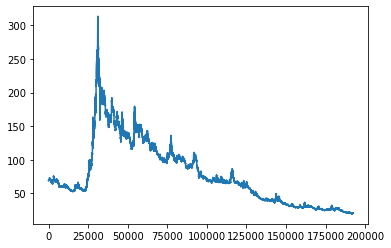

In [9]:
co = "VXX"
plot_closing_prices(co)

### Plot Class Balances

In [10]:
def train_validation_test_split_and_scaling(float_data, train_percent, val_percent):
    
    # Train, validation, test split
    n = len(float_data)

    train_data_end = int(n*train_percent) #0.7
    val_data_end = int(n* (train_percent + val_percent)) #0.9
    test_data_end = n

    # Feature Scaling
    mean = float_data[:train_data_end].mean(axis=0)
    float_data -= mean
    std = float_data[:train_data_end].std(axis=0)
    float_data /= std
    
    return float_data, train_data_end, val_data_end,test_data_end

def generator_and_label_provider(actual_close_prices,step, delay,val_data_end):

    # Get test data and test labels
    test_data = float_data[val_data_end:]
    test_prices = actual_close_prices[val_data_end:]

    test_values_list = []

    # Saves test data in chunks and labels and misc data for evaluations and result logging
    for x in range(lookback, len(test_data) - delay, step):        
        end_price = test_prices[x+delay]
        beg_price = test_prices[x]
        value_change = (end_price - beg_price) / beg_price
        test_values_list.append(value_change)

    # Converts percent values to binary labels
    test_labels = []

    for label in test_values_list:
        if label > 0:
            test_labels.append(1)
        else:
            test_labels.append(0)

    test_labels = np.asarray(test_labels)

    # Counts class instances, for class balance checks
    zero_count = 0
    one_count = 0

    for label in test_labels:
        if label == 0:
            zero_count += 1
        else:
            one_count += 1
    
    return zero_count, one_count

In [11]:
###############################################################################################
# Import List of Stocks and Proxies
###############################################################################################

# List of Stocks
CoList = pd.read_excel('Input Files/List of ETFs.xlsx',sheet_name='Low_Missing')
CoList = CoList['Symbol']

# List of Proxies
proxies = pd.read_excel('Input Files/List of ETFs.xlsx',sheet_name='Proxies')

proxies = proxies['Symbol']

# List of Market Holidays
holiday_list = list(pd.read_excel('Input Files/Stock Market Holidays.xlsx')['Date'])
holiday_list = [holiday.strftime('%Y-%m-%d') for holiday in holiday_list]

################## Set Interval #######################
# 1min, 5min, 15min, 30min, 60min
minute_interval = '1min'



###############################################################################################
# Set Parameters
###############################################################################################
delay = 30

lookback = 390*3
step = 30

###############################################################################################
# Run Functions to Train all the models, save them, and log the results
###############################################################################################
cos_added = 0
cos_existing = 0

cos = []
zeros = []
ones = []

for co in tqdm(CoList):
    
    ######################### Load in the dataset #############################################

    file = 'AlphaVantage Data/1min/6. Cleaned Combined Data Stationarity/1min '+co+' cleaned_combined_stationary.csv'

    df = pd.read_csv(file)

    df = df.drop(columns=['time','datetime','short_date', 'hour_minute'])

    hours = df['hour']
    minutes = df['minute']
    weekdays = df['weekday']

    actual_close_prices = np.asarray(df['close_prices'])
    float_data = df.to_numpy()

    ################################## Split into Train, Validation, and Test data, and scale features ##################
    # 65% train data, 15% validation data, 20% Test Data
    float_data, train_data_end, val_data_end,test_data_end = train_validation_test_split_and_scaling(float_data, .70, .20)

    ############################# Create Data Generators and Make Labels and Testing Aids ######################
    zero_count, one_count = generator_and_label_provider(actual_close_prices,step, delay,val_data_end)
        
    cos.append(co)
    zeros.append(zero_count)
    ones.append(one_count)
    
df = pd.DataFrame()
df['Ticker'] = cos
df['0s'] = zeros
df['1s'] = ones
df['% 0s'] = df['0s'] / (df['0s'] + df['1s'])

100%|██████████| 54/54 [04:12<00:00,  4.67s/it]


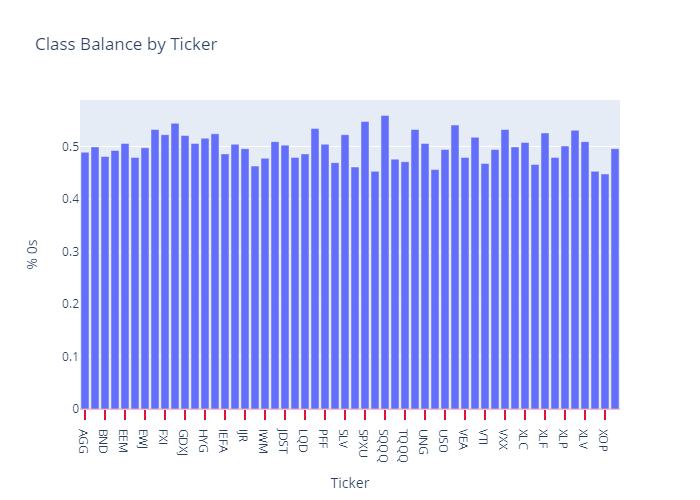

In [12]:
fig = px.bar(df, x='Ticker', y='% 0s',
                labels=dict(value='Data % as Class 0', variable="Ticker"),title="Class Balance by Ticker")

fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='crimson', ticklen=10)
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightPink')

#fig.show()
fig.show(renderer="png")

### Plot of Model ROCs

This plot shows the overall ROC Scores for each stock's model.

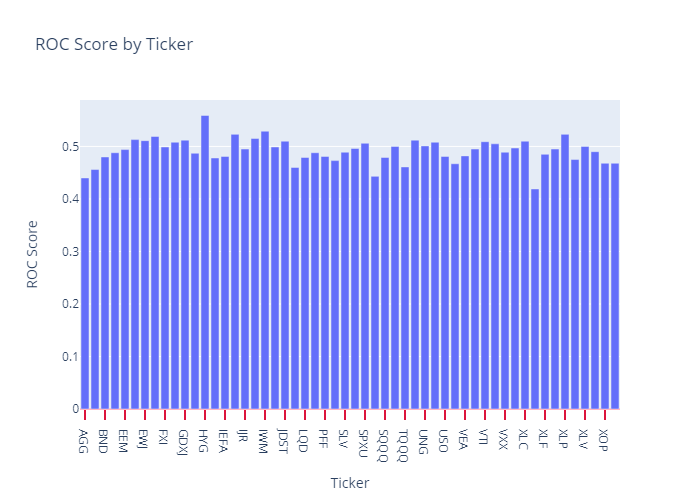

Models With ROC Scores greater than 50%:  18


In [14]:
# Load File
file_name =  'Result Log by Delay - 30 min.csv'
file = pathlib.Path.cwd() / 'Logs'/ 'Result Logs' / 'By Delay' / file_name 
df = pd.read_csv(file)
df['ROC Score'] = df['ROC Score'].str.rstrip('%').astype('float') / 100.0

# Get List of Tickers
tickers = list(set(list(df['Ticker'])))
tickers = sorted(tickers)

    
fig = px.bar(df, x='Ticker', y='ROC Score',
                labels=dict(value='ROC Score (0 to 1)', variable="Ticker",Returns='Avg. ROC Score'),title="ROC Score by Ticker")

fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='crimson', ticklen=10)
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightPink')

#fig.show()
fig.show(renderer="png")

df_slice = df.loc[(df['ROC Score'] > .50)]
print("Models With ROC Scores greater than 50%: ",len(df_slice))

### Calculate Average Window Return

Function to calculate the average price change for each window for a stock

In [15]:
def calculate_window_returns(window, hour, weekday, co):
    returns = []

    file_name = minute_interval + " " + co + ' cleaned_combined.csv'
    file = pathlib.Path.cwd() / 'AlphaVantage Data'/ minute_interval / '3. Cleaned Combined Data' / file_name 
    df = pd.read_csv(file)

    for x in range(0,len(df)-window,window):
        if hour == 'all' and weekday == 'all': 
            beginning = df['close'][x]
            end = df['close'][x+window]

            percent_change = (end - beginning) / beginning
            returns.append(percent_change)

        elif hour == 'all' and weekday != 'all':
            if df['weekday'][x] == weekday:
                beginning = df['close'][x]
                end = df['close'][x+window]

                percent_change = (end - beginning) / beginning
                returns.append(percent_change)

        elif hour != 'all' and weekday == 'all':
            if df['hour'][x] == hour:
                beginning = df['close'][x]
                end = df['close'][x+window]

                percent_change = (end - beginning) / beginning
                returns.append(percent_change)

        else:
            if df['hour'][x] == hour and df['weekday'][x] == weekday:
                beginning = df['close'][x]
                end = df['close'][x+window]

                percent_change = (end - beginning) / beginning
                returns.append(percent_change)
                
    return returns

#### Specific Window

This function calculates the percent return for one specific window for a stock.

In [16]:
window = 30
# 'all' or 9-15
hour = 'all'
# 'all' or 0-4
weekday = 'all'

co = 'DIA'

window_returns = calculate_window_returns(window, hour, weekday, co)
print(round(statistics.mean(window_returns)*100,5),"%")

0.00553 %


#### Plot All Windows

This plot shows the average % returns for each trading window of the week for a specific stock.

In [19]:
def plot_all_windows(co, window):
    
    # Get average returns by window
    all_windows_returns = []
    for weekday in range(0,5):
        for hour in range(9,16):
            this_window_returns = []
            window_returns = calculate_window_returns(window, hour, weekday, co)
            this_window_returns.append(statistics.mean(window_returns))
            this_window_average = statistics.mean(this_window_returns)
            all_windows_returns.append(this_window_average*100)

    # Get List of labels.  One for each window
    weekdays = ['Mon','Tues','Weds','Thurs','Fri']
    x_labels = []

    for day in weekdays:
        for hour in range(9,16):
            x_labels.append(day + " " + str(hour))

    # Create DF to plot
    df = pd.DataFrame()
    df['Returns'] = all_windows_returns
    df['Window'] = x_labels

    # Make Bar Chart of all windows
    fig, ax1 = plt.subplots()

    figure(figsize=(10,10))

    ax1 = df['Returns'].plot(ax=ax1, kind="bar", color="orange", legend=False)

    ax1.set_ylabel("Window Return (in %)")
    ax1.set_xlabel("Windows of the Week ")

    ax1.set_xticklabels(df['Window'])
    plt.show()

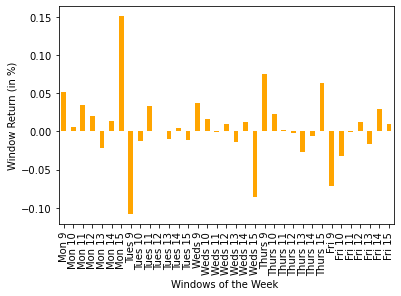

<Figure size 720x720 with 0 Axes>

In [20]:
co = 'DIA'
window = 30

plot_all_windows(co, window)

## Comparing Model Returns Vs. Passive Returns

This plot shows the difference between Model Strategy Percent Return vs. the Passive Strategy's Percent Return

The instances > 0 show that the model improved the investment performance.  The instances < 0 show that an investor would be better of just passively investing in the stock rather than investing when the model tells them to or not to.

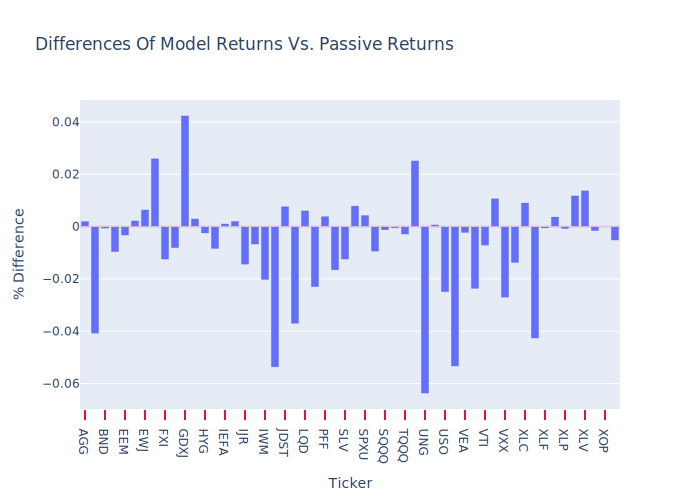

In [21]:
# Load File
file_name =  'Result Log by Window - 30 min.csv'
file = pathlib.Path.cwd() / 'Logs'/ 'Result Logs' / 'By Window' / file_name 
df = pd.read_csv(file)
df['Model - Passive'] = df['Strat Return'] - df['Passive Return']

# Get List of Tickers
tickers = list(set(list(df['Ticker'])))
tickers = sorted(tickers)

# Calculate Average Difference of Model Returns and Passive Returns for Each Ticker
diff_avgs = []

# Plot
for group in df.groupby(by=["Ticker"]):
    tick_avg = statistics.mean(group[1]['Model - Passive']*100)
    diff_avgs.append(tick_avg)
    
fig = px.bar(x=tickers, y=diff_avgs,
                labels=dict(y='% Difference',x='Ticker'),title="Differences Of Model Returns Vs. Passive Returns")

fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='crimson', ticklen=10)
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightPink')

#fig.show()
fig.show("svg")